# Chercher les paires pour les cases dérivationnelles dans Lexique3

In [1]:
import codecs,math,pickle,re,math
import pandas as pd
import numpy as np
import itertools as it
import matplotlib as mplt
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

In [3]:
import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_context("poster")
sns.set_palette("husl")

In [4]:
nomDerifPlat="/Users/gilles/Dropbox/Travail/Recherche/BoKu/LingInfo/AnalyseDerif/AnalyseDeriF-Const.plat"
with codecs.open(nomDerifPlat,"r",encoding="ISO-8859-1") as inFile:
    derifLines=[[e for e in l.strip().split("\t") if e!=""] for l in inFile.readlines()]

In [5]:
mapAllomorphie={"N*":"NOM","V*":"VERBE","A*":"ADJ"}
const1=ur"(ADJ|NOM|NAM|VERBE|QUANT|[NVA]\*)/([^/]+)/(conv|pref?|suf|comp)/(ADJ|NOM|VERBE)"
const2=ur'\+([^/]+)/(ADJ|NOM|NAM|VERBE|QUANT|[NVA]\*)([^",]*)'
regexConst=const1+const2

In [6]:
def ajouterChaines(gRows):
    def transRow2Str(row):
        b=row["base"]
        c=row["construction"]
        d=row["derive"]
        return u"%s—%s—%s"%(b,c,d)
        
    def transStr2Row(chaine):
        lRow={}
        b,c,d=chaine.split(u"—")
        lRow["base"]=b
        lRow["construction"]=c
        lRow["derive"]=d
        return lRow

    def ajouterRows(gRows):
        newRows=set()
        for row in gRows:
            b,c,d=row.split(u"—")
            newRows.add(row)
            if b in baseAnterieure:
                a=baseAnterieure[b]
                newRows.add(u"%s—%s—%s"%(a,c,d))
        return len(newRows),newRows
    
    lDF=pd.DataFrame(gRows)
    bases=lDF["base"].tolist()
    basesDerives=lDF[lDF["derive"].isin(bases)]["derive"].tolist()
    baseAnterieure={}
    for d in basesDerives:
        b=lDF[lDF["derive"]==d]["base"].values[0]
        baseAnterieure[d]=b    
    newRows=[transRow2Str(r) for r in gRows]
    nbRows=len(newRows)
    nbNewRows,newRows=ajouterRows(newRows)
    while nbNewRows>nbRows:
        nbRows=nbNewRows
        nbNewRows,newRows=ajouterRows(newRows)
    lRows=[transStr2Row(s) for s in newRows]
    return lRows

In [7]:
def substituerChaines(gRows):
    def transRow2Str(row):
        b=row["base"]
        c=row["construction"]
        d=row["derive"]
        return u"%s—%s—%s"%(b,c,d)
        
    def transStr2Row(chaine):
        lRow={}
        b,c,d=chaine.split(u"—")
        lRow["base"]=b
        lRow["construction"]=c
        lRow["derive"]=d
        return lRow

    def changerRows(gRows):
        newRows=set()
        for row in gRows:
            b,c,d=row.split(u"—")
            if b in baseAnterieure:
                a=baseAnterieure[b]
                newRows.add(u"%s—%s—%s"%(a,c,d))
            else:
                newRows.add(row)
        return len(newRows),newRows
    
    lDF=pd.DataFrame(gRows)
    bases=lDF["base"].tolist()
    basesDerives=lDF[lDF["derive"].isin(bases)]["derive"].tolist()
    baseAnterieure={}
    for d in basesDerives:
        b=lDF[lDF["derive"]==d]["base"].values[0]
        baseAnterieure[d]=b    
    newRows=[transRow2Str(r) for r in gRows]
    nbRows=len(newRows)
    nbNewRows,newRows=changerRows(newRows)
    while nbNewRows>nbRows:
        nbRows=nbNewRows
        nbNewRows,newRows=changerRows(newRows)
    lRows=[transStr2Row(s) for s in newRows]
    return lRows

In [8]:
constFormeNb={}
constFormeBases={}
dfRows=[]
dfRowsNeutres=[]
nbAllomorphes=0
for i,l in enumerate(derifLines):
#    print i
    if len(l)>1:
        dfRow={}
        dfRowNeutre={}
        m=re.search(regexConst,derifLines[i][1])
        derive=derifLines[i][0].split("=")[0]
#        print derifLines[i][1]
        if m:
            mGroups=list(m.groups())
            construction="/".join(mGroups[0:4])
            base="/".join(mGroups[4:])
            if construction not in constFormeNb:
                constFormeNb[construction]=0
            constFormeNb[construction]+=1
            if construction not in constFormeBases:
                constFormeBases[construction]=set()
            constFormeBases[construction].add((base,derive))
            dfRow["construction"]=construction
            dfRow["base"]=base.strip("/")
            dfRow["derive"]=derive
            dfRows.append(dfRow)
            constructionNeutre=construction
            baseNeutre=base
            mC=re.search(ur"([NVA]\*)(.*)",construction)
            if mC:
                nbAllomorphes+=1
                categorieAllomorphe=mapAllomorphie[mC.group(1)]
                lConstruction=mC.group(2)
                constructionNeutre=categorieAllomorphe+lConstruction
                mB=re.search(ur"^[^/]*/([NVA]\*)/=(.*)$",base)
                if mB:
                    baseNeutre=mB.group(2)+"/"+mapAllomorphie[mB.group(1)]
#                    if ":" in base:
#                        print "base allomorphe", constructionNeutre,baseNeutre,derive
                else:
                    mB2=re.search(ur":(.*)$",base)
                    if mB2:
#                        print "base dans comp",construction,mB2.group(1),derive
                        baseNeutre=mB2.group(1).strip("/")
                    else:
                        print "pas d'allomorphe",construction,base,derive
                    
            dfRowNeutre["construction"]=constructionNeutre
            dfRowNeutre["base"]=baseNeutre.strip("/")
            dfRowNeutre["derive"]=derive
            dfRowsNeutres.append(dfRowNeutre)
        elif "???" not in derifLines[i][1]:
            print "pb avec",l
    else:
        print u"pas de dérif"
#dfDerif=pd.DataFrame(ajouterChaines(dfRows))
#dfDerifNeutre=pd.DataFrame(ajouterChaines(dfRowsNeutres))
dfDerif=pd.DataFrame(substituerChaines(dfRows))
dfDerifNeutre=pd.DataFrame(substituerChaines(dfRowsNeutres))

pas de dérif
pas de dérif
pb avec [u'fondeur/NOM==>', u'2,fondre)/eur/suf/NOM+(fonder/fondre)/VERBE" (Agent habituel - Auteur exceptionnel - Instrument) de (fonder/fondre)"']
pb avec [u'mouleur/NOM==>', u'2,moudre)/eur/suf/NOM+(mouler/moudre)/VERBE" (Agent habituel - Auteur exceptionnel - Instrument) de (mouler/moudre)"']
pb avec [u'op\xe9able/ADJ==>', u'2,SIG/able/suf/ADJ+OPA/SIG" Qui peut (devenir - subir - \xeatre une voie pour - faire l\'objet de) OPA"']
pb avec [u'ouvreur/NOM==>', u'2,ouvrir)/eur/suf/NOM+(ouvrer/ouvrir)/VERBE" (Agent habituel - Auteur exceptionnel - Instrument) de (ouvrer/ouvrir)"']
pas de dérif
pb avec [u'venet/NOM==>', u'2,venir)/et/suf/NOM+(vener/venir)/VERBE"Instrument (\xe9ventuellement petit) ou agent (\xe9ventuellement jeune) de (vener/venir) ou objet/r\xe9sultat (\xe9ventuellement d\xe9risoire) de (vener/venir)"']
pb avec [u'veneur/NOM==>', u'2,venir)/eur/suf/NOM+(vener/venir)/VERBE" (Agent habituel - Auteur exceptionnel - Instrument) de (vener/venir)"']
p

In [9]:
dfDerifNeutre[dfDerifNeutre["construction"].str.contains("^[NVA]\*")]["construction"]
len(dfDerifNeutre["construction"].unique())

986

# Calcul de la HeatMap

In [10]:
def makeParadigmes(gDF):
    lDFParadigmes=gDF.pivot_table(values='derive', index=['base'], columns=['construction'], aggfunc=lambda x: ",".join(x)).reset_index().reindex()
    return lDFParadigmes

In [11]:
def tableauPaires(gParadigme):
    lTable=pd.DataFrame(columns=["ligne","colonne","nbPaires"])
    refCases=gParadigme.columns.tolist()
    for n,paire in enumerate(it.combinations_with_replacement(refCases,2)):
        if n%1000==0:
            print n,paire
        if paire[0] in gParadigme.columns and paire[1] in gParadigme.columns:
            nbPaires=len(gParadigme[[paire[0],paire[1]]].dropna())
        else:
            nbPaires=0
        lTable.loc[2*n]=[paire[0],paire[1],nbPaires]
        lTable.loc[2*n+1]=[paire[1],paire[0],nbPaires]
    print "table finie"
    lTable=lTable.drop_duplicates()
    lTable["nbPaires"]=lTable["nbPaires"].astype(int)
    lTableau=lTable.pivot_table(index="ligne",columns=["colonne"])
    #
    # Ici, il faut renvoyer le tableau["nbPaires"] pour éviter l'enchassemement des colonnes
    #
    return lTableau["nbPaires"]

In [12]:
def getTableauPaire(gDF,thresh=3):
    threshCol=thresh
    colThresh=[k for k,v in gDF.count().to_dict().iteritems() if v>=threshCol]
    nbCols=len(colThresh)
    f=math.factorial
    print f(nbCols) //2 // f(nbCols-2),"paires"

    tableauDerif=tableauPaires(gDF[sorted(colThresh)])
    return tableauDerif

In [13]:
def sortCellFrequency(df):
    return pd.Series(np.diag(df),index=df.index).sort_values(ascending=False).index.tolist()

In [14]:
def heatmap(gDF):
    fig, ax = plt.subplots(figsize=(60,50))
#    ax.set_ylabel('Cells sorted by decreasing frequency')    
#    ax.set_xlabel('Cells sorted by decreasing frequency')
    sns.heatmap(gDF,cmap="Oranges",norm=norm,annot=True,fmt="g",cbar_kws={"ticks":bounds},ax=ax,cbar=True)
    return

In [15]:
def getHeatTable(gDF,inflectionPar=51):
    lDF=gDF.copy()
    sortedSampleCases=sortCellFrequency(lDF)[:inflectionPar]
    sortedSampleCases.remove("base")
    print sortedSampleCases
    lDF=lDF[sortedSampleCases]
    lDF=lDF.reindex(sortedSampleCases[::-1])
    lDF=lDF.tail(inflectionPar)
    return lDF

In [20]:
def makeHeatMap(gDF):
    heatmap(gDF)
    plt.xlabel('Cells sorted by decreasing frequency',fontsize=48) 
    plt.ylabel('Cells sorted by decreasing frequency',fontsize=48) 
    plt.xticks(fontsize=36, rotation=90) 
    plt.yticks(fontsize=36, rotation=0)
    plt.savefig("HM-DerifLex3.pdf", bbox_inches='tight')

In [17]:
bounds = np.array([0, 30, 300, 2000, 5000])
norm = mplt.colors.BoundaryNorm(boundaries=bounds, ncolors=100)

In [18]:
def computeHeatMap(gDF,thresh=3):
    lDFParadigmes=makeParadigmes(gDF)
    lDF=getTableauPaire(lDFParadigmes,thresh=thresh)
    lDFHeat=getHeatTable(lDF)
    makeHeatMap(lDFHeat)
    return lDFParadigmes,lDF,lDFHeat

34453 paires
0 (u'ADJ/a/pre/ADJ', u'ADJ/a/pre/ADJ')
1000 (u'ADJ/auto/pre/ADJ', u'NOM/t\xe9l\xe9/pre/NOM')
2000 (u'ADJ/conv/conv/NOM', u'NOM/re/pre/VERBE')
3000 (u'ADJ/d\xe91/pre/VERBE', u'NOM/porte:ADJ/comp/NOM')
4000 (u'ADJ/ifier/suf/VERBE', u'NOM/post/pre/NOM')
5000 (u'ADJ/mal/pre/ADJ', u'NOM/spectre:NOM/comp/NOM')
6000 (u'ADJ/re/pre/ADJ', u'NOM/xylo:N*/comp/NOM')
7000 (u'ADJ/tri/pre/ADJ', u'NOM/age/suf/NOM')
8000 (u'NAM/al/suf/ADJ', u'NOM/h\xe9mi:A*/comp/NOM')
9000 (u'NOM/a/pre/ADJ', u'NOM/st\xe9r\xe9o:A*/comp/NOM')
10000 (u'NOM/ad\xe9n:N*/comp/NOM', u'NOM/dod\xe9ca/pre/NOM')
11000 (u'NOM/alcali:N*/comp/NOM', u'NOM/sub/pre/NOM')
12000 (u'NOM/apr\xe8s/pre/NOM', u'NOM/inter/pre/NOM')
13000 (u'NOM/avant/pre/NOM', u'NOM/di/pre/ADJ')
14000 (u'NOM/bio:N*/comp/NOM', u'VERBE/mono/pre/ADJ')
15000 (u'NOM/co/pre/NOM', u'VERBE/eur/suf/NOM')
16000 (u'NOM/cry:N*/comp/NOM', u'NOM/di/pre/ADJ')
17000 (u'NOM/di/pre/ADJ', u'NOM/inter/pre/NOM')
18000 (u'NOM/dynam:N*/comp/NOM', u'NOM/sub/pre/NOM')
19000

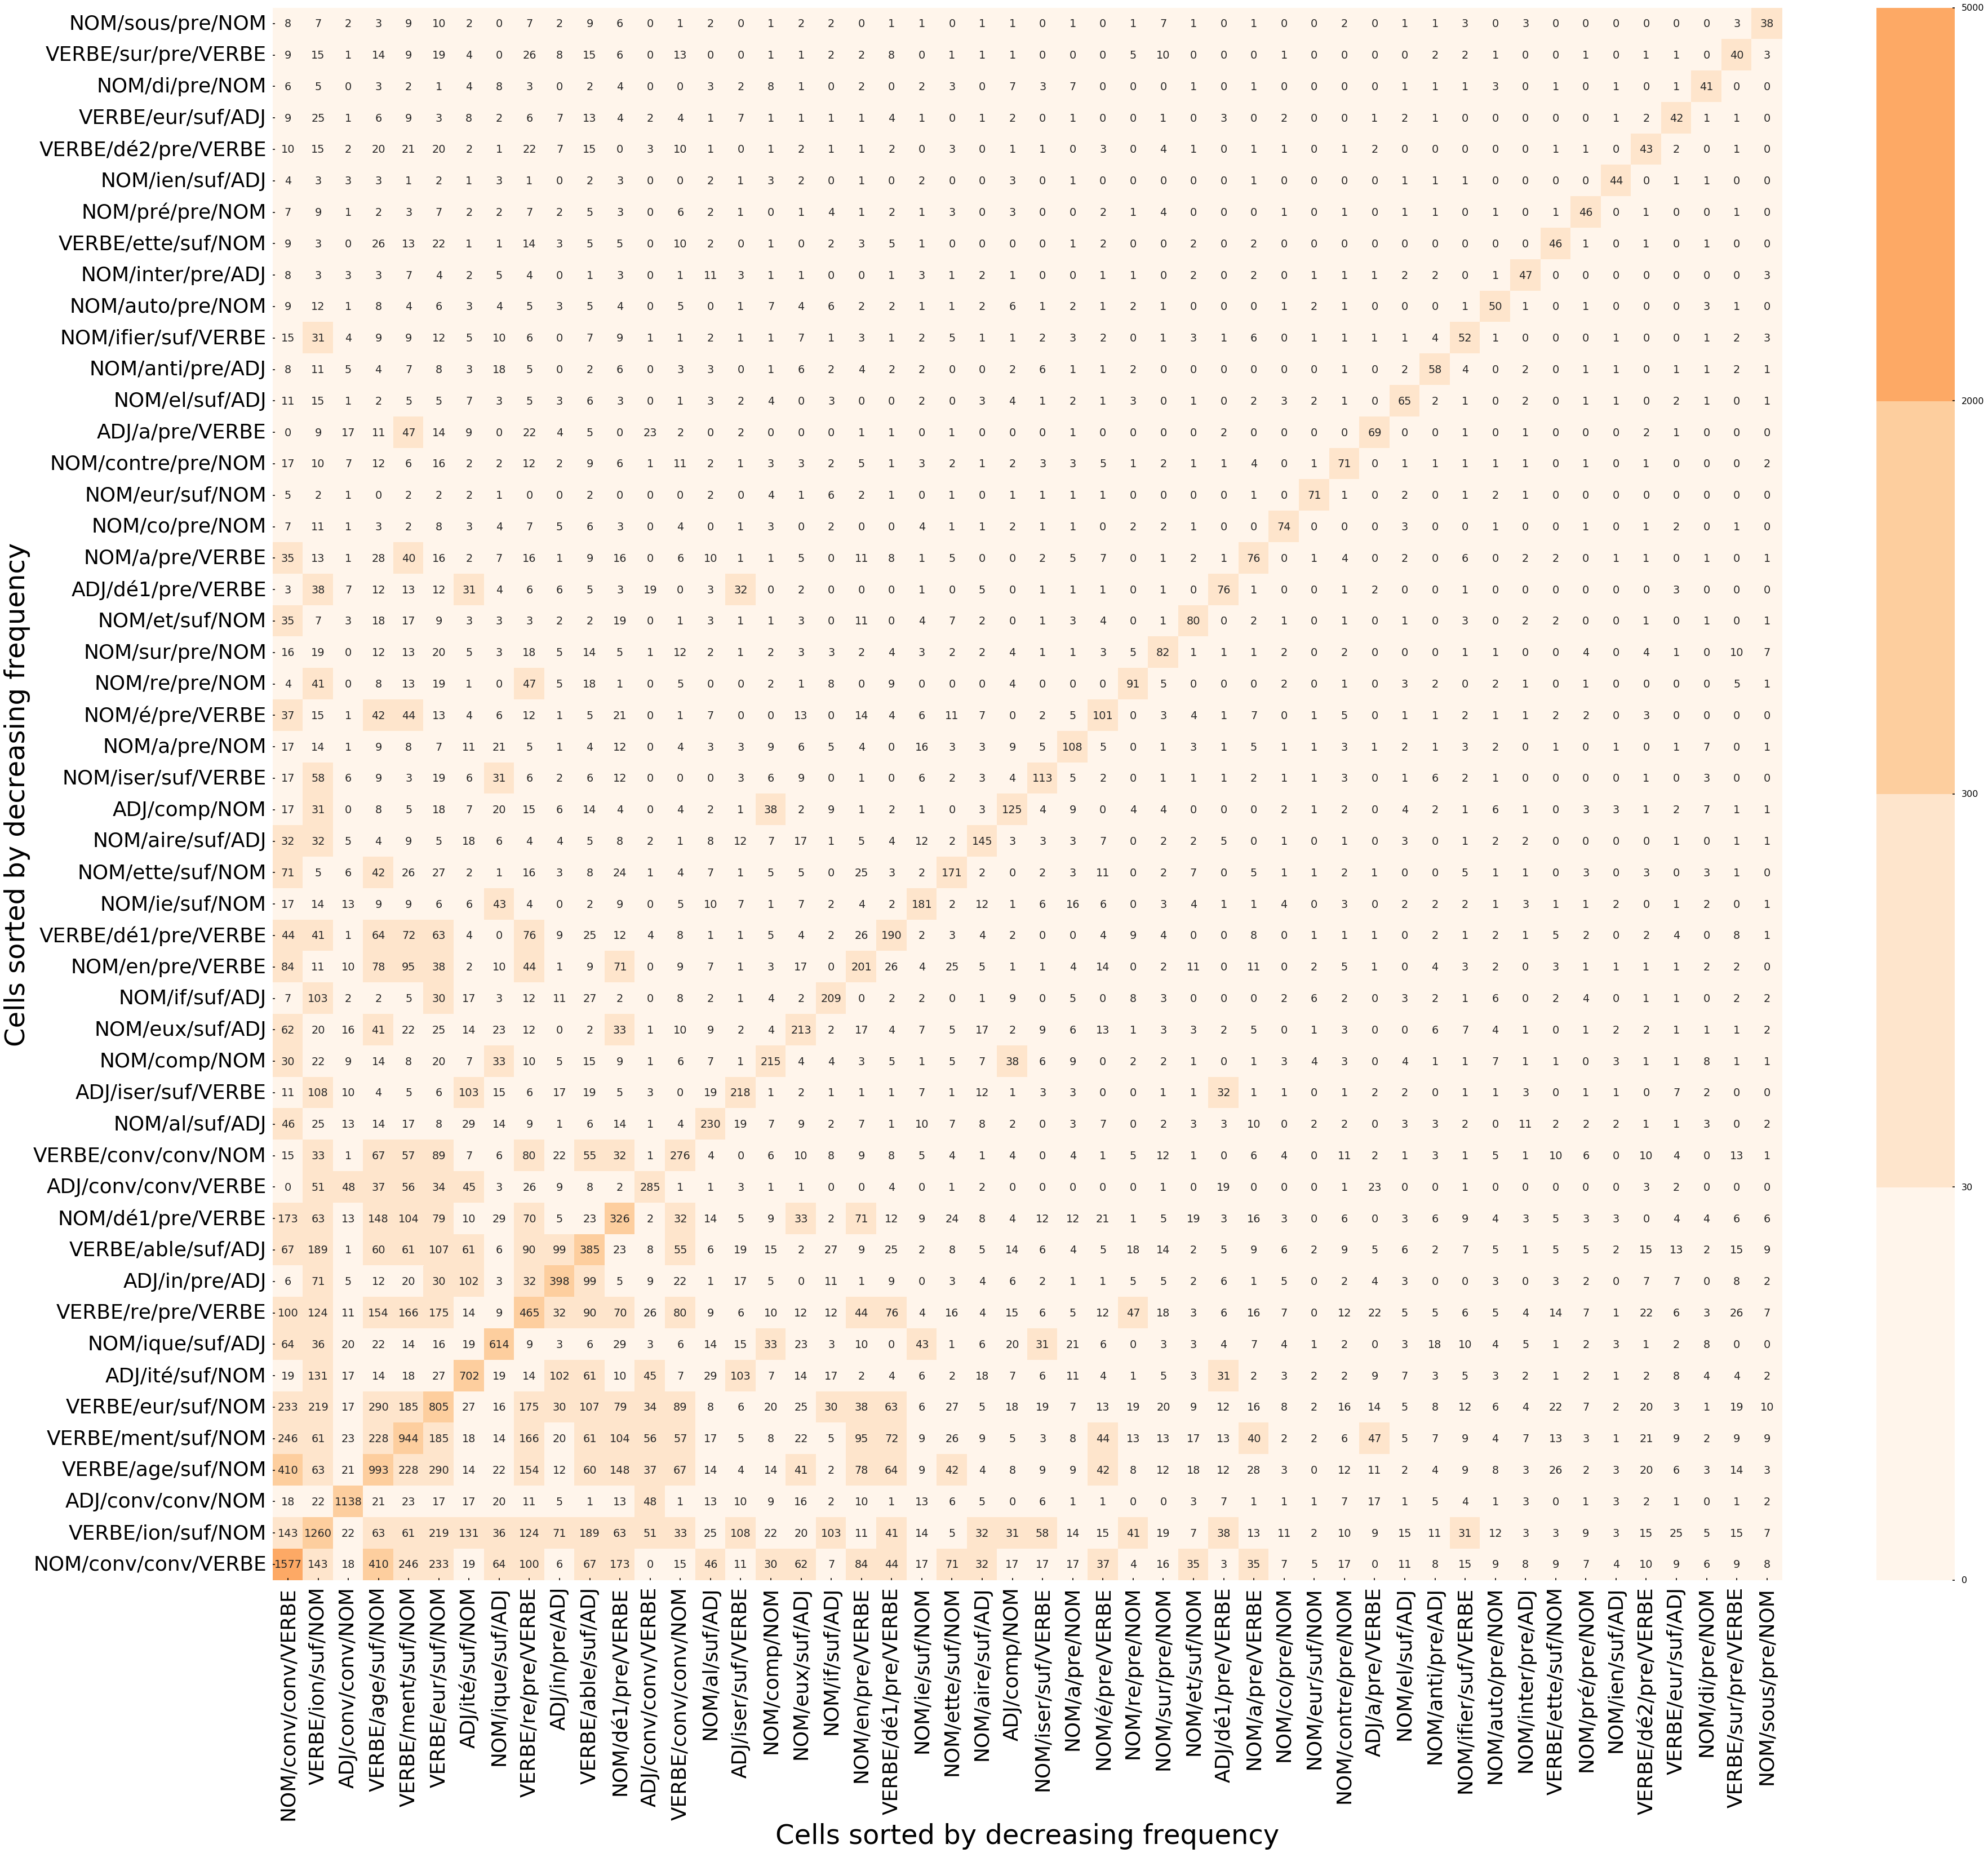

In [19]:
df1,df2,df3=computeHeatMap(dfDerifNeutre)

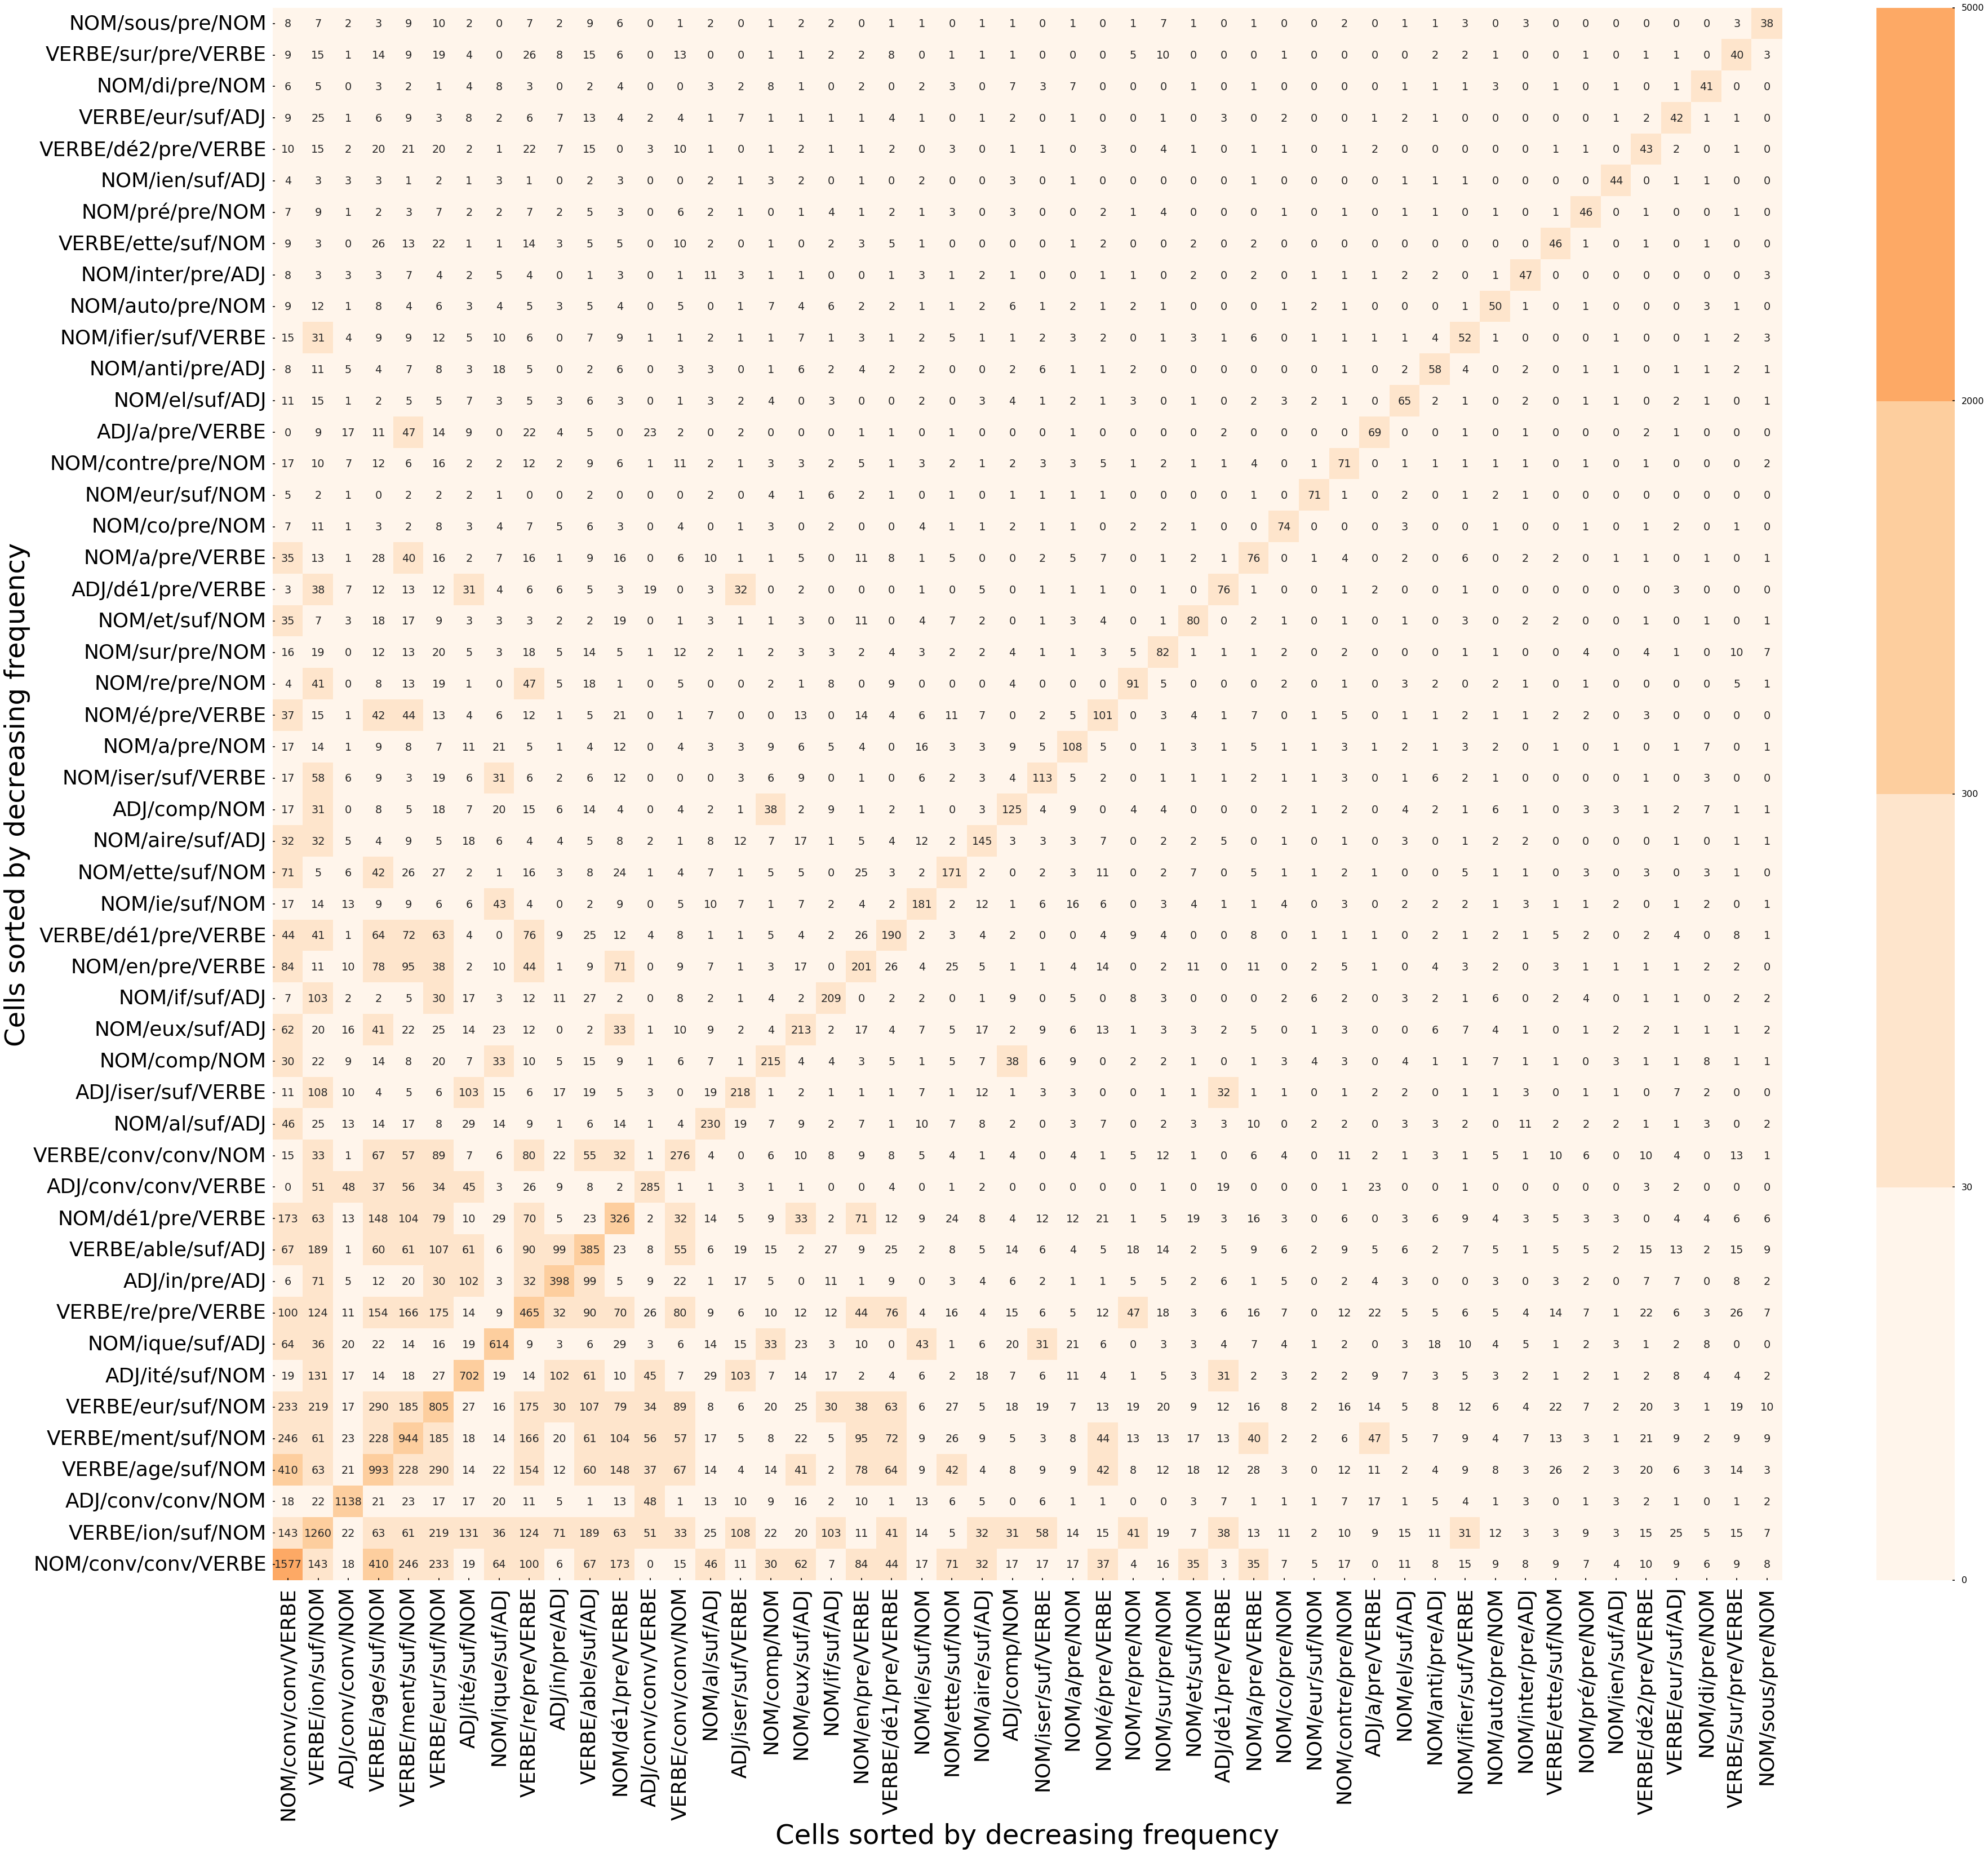

In [21]:
makeHeatMap(df3)

In [ ]:
listeChaines=[u"éviter/VERBE",u"évitable/ADJ"]
df1[df1["base"]==listeChaines[1]].values.tolist()

In [ ]:
df1

In [ ]:
thresh=1
constThresh={k:v for k,v in constFormeNb.iteritems() if v>=thresh}
constThresh

In [ ]:
derifBases={}
for c in constThresh:
    for b,d in constFormeBases[c]:
        if b not in derifBases:
            derifBases[b]=set()
        derifBases[b].add((c,d))
derifBases

In [ ]:
threshBase=1
basesThresh={k:v for k,v in derifBases.iteritems() if len(v)>=threshBase}
basesThresh

In [ ]:
tableauParadigmes={}
for b in basesThresh:
    p=set()
    for c,d in basesThresh[b]:
        p.add(c)
    paradigme=",".join(sorted(p))
    if paradigme not in tableauParadigmes:
        tableauParadigmes[paradigme]=0
    tableauParadigmes[paradigme]+=1
tableauParadigmes